In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

In [3]:
cuda = True
seed = 42
use_cuda = cuda and torch.cuda.is_available()

# Set seed
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# Handel GPU stochasticity
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
original_size = 96
cropped_size = 64
num_channels = 3
num_classes = 10


## STL-10 dataset

The images in STL-10 dataset simiilar to CIFAR-10 dataset but with higher resolution - 3 color channels of 96x96 images.

![stl_10.png](stl_10.png)

## Data Loader

In [5]:
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean, std)])

train_transform=transforms.Compose([
                    transforms.Pad(4),
                    transforms.RandomCrop(cropped_size),
                    # transforms.RandomHorizontalFlip(),
                    # transforms.RandAugment(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=1)


test_transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.CenterCrop(cropped_size),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])
testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)


Files already downloaded and verified
Files already downloaded and verified


In [6]:

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

## Visualize the data

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imgs_dict = dict(zip(classes, [[],[],[],[],[],[],[],[],[],[]]))
counters_dict = dict(zip(classes, [0]*10))

while not all(v >= 4 for v in counters_dict.values()):
    images, labels = dataiter.next()
    for image, label in zip(images, labels):
        img_class = classes[label]
        if(counters_dict[img_class] < 4):
            imgs_dict[img_class].append(image)
            counters_dict[img_class] += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane


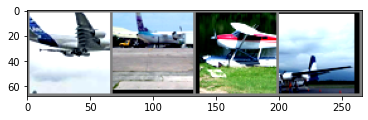

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


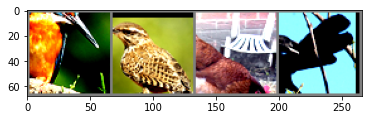

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


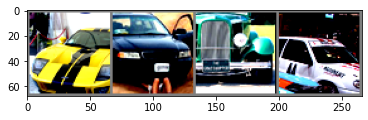

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


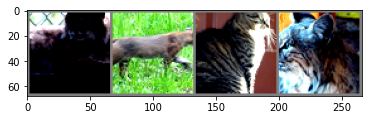

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


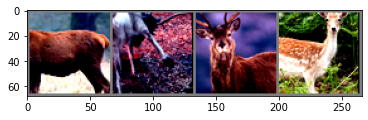

dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


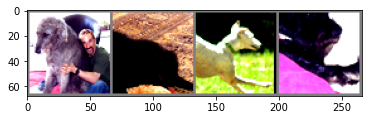

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


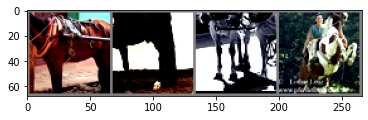

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


monkey


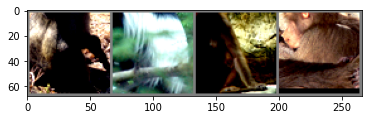

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


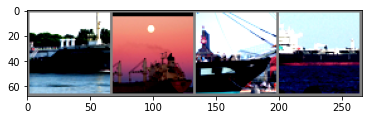

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


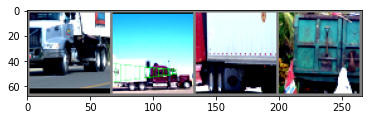

In [8]:
# show images
for l,imgs in imgs_dict.items():
    print(l)
    imshow(torchvision.utils.make_grid(imgs, nrow=4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


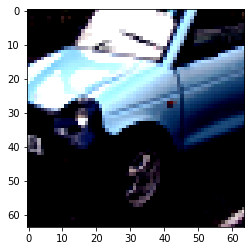

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


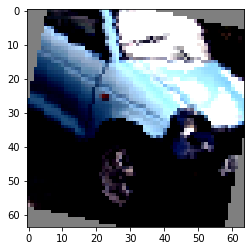

In [9]:
# show an image and its augmented version:
# we choose to add to our dataloader a horizontal flip, and a random rotation of 20 degrees:
rotater = transforms.RandomRotation(degrees=(0,30))
fliper = transforms.RandomHorizontalFlip(p=0.5)
fliper_for_visualization = transforms.RandomHorizontalFlip(p=1)
images,_ = dataiter.next()
img = images[0]
plt.figure()
imshow(img)
img_aug = rotater(img)
img_aug = fliper_for_visualization(img_aug)
plt.figure()
imshow(img_aug)

In [10]:
def train(net, trainloader, num_epochs=50, validation_ratio = 0.2, augment=False):
	criterion = nn.CrossEntropyLoss()
	# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
	optimizer = optim.Adam(net.parameters(), lr=0.0001)
	epoch_pbar =  tqdm(range(num_epochs))
	assert 0.05 < validation_ratio < 0.4
	save_for_val_every =  int(1/validation_ratio)
	val_inputs, val_labels = [],[]
	
	for epoch in epoch_pbar:  # loop over the dataset multiple times
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		net.num_epochs += 1
		for i, data in enumerate(trainloader, 0):
			# get the inputs; data is a list of [inputs, labels]
			inputs, labels = data
			inputs = inputs.to(device)
			labels = labels.to(device)
            
			if i % save_for_val_every == save_for_val_every - 1:
				# save for validation
				val_inputs.append(inputs)
				val_labels.append(labels)
			else:
				#train
				total_train += labels.size(0)

				if augment: # augmentation
					inputs = rotater(inputs)
					inputs = fliper(inputs)
				# zero the parameter gradients
				optimizer.zero_grad()

				# forward + backward + optimize
				outputs = net(inputs)
				loss = criterion(outputs, labels)
				loss.backward()
				optimizer.step()
                
				_, predicted = torch.max(outputs.data, 1)
				correct_train += (predicted == labels).sum().item()
				# print statistics
				running_loss += loss.item()
				# if i % 2000 == 1999:    # print every 2000 mini-batches
				# 	print('[%d, %5d] loss: %.3f' %
				# 		(epoch + 1, i + 1, running_loss / 2000))
				# 	running_loss = 0.0
        
		epoch_loss = running_loss/total_train
		net.train_loss_list.append(epoch_loss)
		net.train_accuracy.append(100*correct_train/total_train)
		
		#validation
		correct_val = 0
		total_val = 0
		val_loss = 0
		with torch.no_grad():
			for inputs, labels in zip(val_inputs, val_labels):
				outputs = net(inputs)
				total_val += labels.size(0)
				val_loss += criterion(outputs, labels).item()
				_, predicted = torch.max(outputs.data, 1)
				correct_val += (predicted == labels).sum().item()      
			net.val_accuracy.append(100*correct_val/total_val)
			net.val_loss_list.append(val_loss/total_val)


		epoch_pbar.set_postfix({'epoch': epoch, 'train loss': running_loss, 'val_accuracy': (100 * correct_val / total_val)})
		# epoch_pbar.set_postfix({'epoch': epoch, 'train accuracy': train_acc, 'train loss': train_loss, \
        #                      'val accuracy': val_acc, 'val loss': val_loss})

	print('Finished Training')

In [11]:
def test(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' \
         % (100 * correct / total))


In [12]:
def show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy,
						num_epochs, title, figsize = (8, 8)):

	fig, axes = plt.subplots(1, 2, figsize=figsize);
	axes[0].set_xlabel('epochs')
	axes[0].set_ylabel('loss')
	axes[0].plot(range(num_epochs), train_loss_list, label="Train", color='blue')
	axes[0].plot(range(num_epochs), val_loss_list, label="Validation", color='red')
	axes[0].legend()
	axes[0].set_title('Loss vs Epoch')


	axes[1].set_xlabel('epochs')
	axes[1].set_ylabel('accuracy')  # we already handled the x-label with ax1
	axes[1].plot(range(num_epochs), train_accuracy, label="Train", color='blue')
	axes[1].plot(range(num_epochs), val_accuracy, label="Validation", color='red')
	axes[1].legend()
	axes[1].set_title('Accuracy vs Epoch')

	fig.suptitle(title)


	#     fig.suptitle('Logistic Regression:\n\n learning rate = {}   |   batch size = {}   |   L2 lambda = {}'
	#                      .format(lr, batch_size, l2_lambda))

	#     return fig;

In [13]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(cropped_size*cropped_size*num_channels, num_classes).to(device)
        )
        self.num_epochs = 0
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_accuracy = []
        self.val_accuracy = []

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def history(self):
        return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs


In [14]:
net = LogisticRegression().to(device)
train(net, trainloader)  
show_learning_curve(*net.history(), title="Learning Curves - Logistic Regression")
# summary(net, (num_channels, cropped_size, cropped_size))

  6%|▌         | 3/50 [00:12<03:17,  4.20s/it, epoch=2, train loss=1.17e+3, val_accuracy=21.5]


KeyboardInterrupt: 

In [ ]:
# train(net, trainloader)  

In [ ]:
test(net, testloader)

Accuracy of the network on the 10000 test images: 22 %


In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
	        nn.Linear(cropped_size*cropped_size*num_channels, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
			nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
			nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
			nn.Linear(512, 512),
            nn.ReLU(),
			nn.BatchNorm1d(512),
			nn.Dropout(0.5),
            nn.Linear(512, 10)
        ).to(device)
        self.num_epochs = 0
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_accuracy = []
        self.val_accuracy = []

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def history(self):
        return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

100%|██████████| 50/50 [03:57<00:00,  4.74s/it, epoch=49, train loss=997, val_accuracy=25.7]    


Finished Training


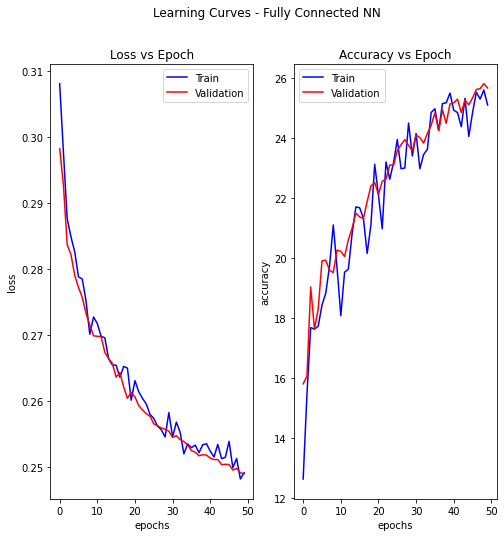

In [ ]:
net = FullyConnectedNN().to(device)
train(net, trainloader)  
show_learning_curve(*net.history(), title="Learning Curves - Fully Connected NN")

In [ ]:
test(net, testloader)

Accuracy of the network on the 10000 test images: 27 %


In [ ]:
class ConvNN(nn.Module):
	def __init__(self):
		super(ConvNN, self).__init__()
		self.feature_extraction = nn.Sequential(
			nn.Conv2d(num_channels, 128, 3),   # 64  64  3  => 31  31 
			nn.ReLU(),
			nn.BatchNorm2d(128),
			nn.MaxPool2d(2),
			nn.Conv2d(128, 64, 3),
			nn.ReLU(),
			nn.BatchNorm2d(64),
			nn.MaxPool2d(2),
		).to(device)
		self.flatten = nn.Flatten().to(device)
		self.linear_relu_stack = nn.Sequential(
			nn.Linear(12544, 1024),
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(1024, 512),
            nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(512, 10)
		).to(device)

		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):
		x = self.feature_extraction(x)
		x = self.flatten(x) 
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

In [ ]:
net = ConvNN().to(device)
summary(net, (num_channels, cropped_size, cropped_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 62, 62]           3,584
              ReLU-2          [-1, 128, 62, 62]               0
       BatchNorm2d-3          [-1, 128, 62, 62]             256
         MaxPool2d-4          [-1, 128, 31, 31]               0
            Conv2d-5           [-1, 64, 29, 29]          73,792
              ReLU-6           [-1, 64, 29, 29]               0
       BatchNorm2d-7           [-1, 64, 29, 29]             128
         MaxPool2d-8           [-1, 64, 14, 14]               0
           Flatten-9                [-1, 12544]               0
           Linear-10                 [-1, 1024]      12,846,080
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
             ReLU-14                  [

100%|██████████| 50/50 [08:45<00:00, 10.52s/it, epoch=49, train loss=495, val_accuracy=64.9]  

Finished Training


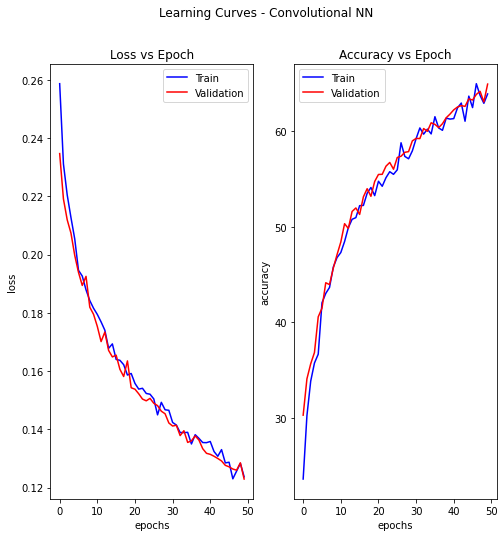

In [ ]:
train(net, trainloader)  
show_learning_curve(*net.history(), title="Learning Curves - Convolutional NN")

In [ ]:
test(net,testloader)

Accuracy of the network on the 10000 test images: 57 %


In [16]:
class MobileNetV2FetureExt_FrozenNN(nn.Module):
	def __init__(self, pretrained=True):
		super(MobileNetV2FetureExt_FrozenNN, self).__init__()
		self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True).to(device)
		# Freeze all layers
		for param in self.feature_extractor.parameters():
			param.requires_grad = False
		# Unfreeze last layer (1000 neurons):
		params = self.feature_extractor.state_dict()
		params.get('classifier.1.weight').requires_grad = True
		params.get('classifier.1.bias').requires_grad = True
		# Add the top layer to the model.
		# It consists of Relu, dropout, and an additional Fully Connected (1000 neurons as well) with
		# Relu and dropout as well. After that comes the classification layer (10 neurons)
		self.linear_relu_stack = nn.Sequential(
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 1000),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 10)).to(device)


		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):

		x = self.feature_extractor(x)
		# x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs


In [19]:
torch.cuda.empty_cache()
# net = MobileNetV2FetureExt_FrozenNN()
# summary(net, (num_channels, cropped_size, cropped_size))

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [15]:
train(net, trainloader,200)
show_learning_curve(*net.history(), title="Learning Curves - MobileNetV2 (Frozen Conv Blocks)")

 35%|███▌      | 70/200 [05:37<10:26,  4.82s/it, epoch=69, train loss=1.17e+3, val_accuracy=23]  


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 5.80 GiB total capacity; 3.37 GiB already allocated; 48.44 MiB free; 3.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
class MobileNetV2FetureExtNN(nn.Module):
	def __init__(self, pretrained=True):
		super(MobileNetV2FetureExtNN, self).__init__()
		self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False).to(device)

		# This time we only add the top layer to the model.
		# It consists of Relu, dropout, and an additional Fully Connected (1000 neurons as well) with
		# Relu and dropout as well. After that comes the classification layer (10 neurons)
		self.linear_relu_stack = nn.Sequential(
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 1000),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(1000, 10)).to(device)


		self.num_epochs = 0
		self.train_loss_list = []
		self.val_loss_list = []
		self.train_accuracy = []
		self.val_accuracy = []

	def forward(self, x):

		x = self.feature_extractor(x)
		# x = self.flatten(x)
		logits = self.linear_relu_stack(x)
		return logits

	def history(self):
		return self.train_loss_list, self.val_loss_list, self.train_accuracy, self.val_accuracy, self.num_epochs

In [ ]:
net = MobileNetV2FetureExtNN(pretrained = False).to(device)
summary(net, (num_channels, cropped_size, cropped_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             ReLU6-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]           1,536
      BatchNorm2d-11           [-1, 96, 32, 32]             192
            ReLU6-12           [-1, 96, 32, 32]               0
           Conv2d-13           [-1, 96, 16, 16]             864
      BatchNorm2d-14           [-1, 96,

Using cache found in /home/user/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
train(net, trainloader, 200)
show_learning_curve(*net.history(), title="Learning Curves - MobileNetV2 (Whole Model Trainable)")

NameError: name 'train' is not defined